# Quickstart: The Rydberg Blockade

The following walkthrough highlights some of Pulser's core features and uses them to display a crucial physical effect for neutral atom devices: the **Rydberg blockade**. Bear in mind that it is not meant to be a comprehensive step-by-step guide on how to use Pulser, but rather a showcase of Pulser in action. 

For a more detailed introduction to Pulser, check the tutorials on [Pulse Sequence Creation](tutorials/creating.nblink) and [Simulation of Sequences](tutorials/simulating.nblink). To better understand neutral atom devices and how they serve as quantum computers and simulators, check the pages in [Quantum Computing with Neutral Atoms](review.rst).

## Pulser's main features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pulser
from pulser_simulation import QutipEmulator

With ``pulser``, it is easy to define a ``Register`` consisting of any arrangement of atoms in a quantum processor. For example, we can generate a register with hexagonal shape:

In [ ]:
layers = 3
reg = pulser.Register.hexagon(layers)
reg.draw(with_labels=False)

In fact, we can place the atoms in arbitrary positions by specifying the positions of each one. As an exotic example, here is a picture of the Gioconda as a register of neutral atoms made using Pulser:

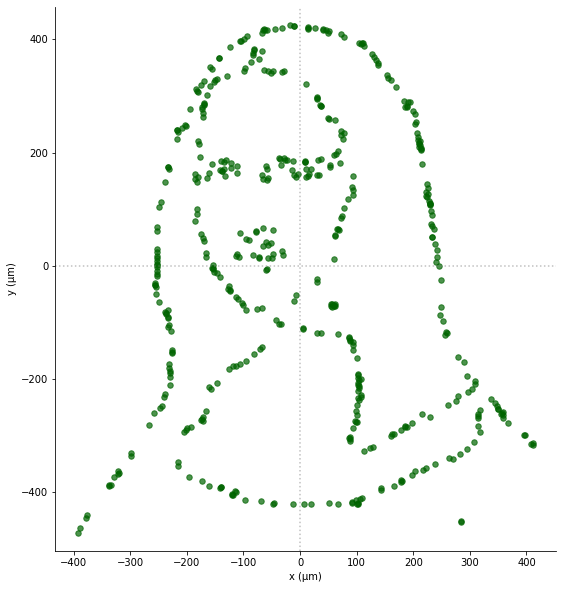

It is also simple to create and design a ``Pulse`` that will act on the atom array:

In [ ]:
duration = 1000  # Typical: ~1 µsec
pulse = pulser.Pulse(
    amplitude=pulser.BlackmanWaveform(duration, np.pi),
    detuning=pulser.RampWaveform(duration, -5.0, 10.0),
    phase=0,
)
pulse.draw()

Each pulse acts on a set of atoms at a certain moment of time. The entire ``Sequence`` is stored by Pulser and can then be either simulated or sent to a real device. Below is the example of a sequence sending the same $\pi$-pulse to two atoms, sequentially, using the same channel.

In [ ]:
reg = pulser.Register.rectangle(1, 2, spacing=8, prefix="atom")
reg.draw()

pi_pulse = pulser.Pulse.ConstantDetuning(
    pulser.BlackmanWaveform(duration, np.pi), 0.0, 0.0
)

seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)

seq.declare_channel("ryd", "rydberg_local", "atom0")

seq.add(pi_pulse, "ryd")
seq.target("atom1", "ryd")
seq.add(pi_pulse, "ryd")

seq.draw()

## Probing the Rydberg Blockade Mechanism

Rydberg atoms are a prominent architecture for exploring condensed matter physics and quantum information processing. For example, one can use Pulser to write a sequence of succesive $\pi$-pulses on a two atom system, each one coupling the atom to its excited Rydberg state. This will allow us to study the *Rydberg Blockade* effect, using the dedicated ``pulser_simulation`` library:

The presence of the van der Waals interaction when both atoms are in the Rydberg state, prevents the collective ground state $|gg\rangle$ to couple to $|rr\rangle$, which is shifted out of resonance. 

The Hamiltonian for the two-atom system can be written as:

$$H = \frac{\hbar \Omega_1(t)}{2} \sigma_1^x + \frac{\hbar \Omega_2(t)}{2} \sigma_2^x + U n_1n_2 $$

We shall explore this blockade by changing the interatomic distance $R$:

In [ ]:
data = []
distances = np.linspace(6.5, 14, 7)

r = [1, 0]  # |r>
rr = np.kron(r, r)  # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

for i, R in enumerate(distances):
    # Atom Register and Device
    reg = pulser.Register.rectangle(1, 2, spacing=R, prefix="atom")

    # Pulse Sequence
    seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
    seq.declare_channel("ryd", "rydberg_local", "atom0")
    seq.add(pi_pulse, "ryd")
    seq.target("atom1", "ryd")
    seq.add(pi_pulse, "ryd")

    sim = QutipEmulator.from_sequence(seq)

    res = sim.run()  # Returns a SimulationResults instance
    data.append(
        res.expect(occup)[0]
    )  # Get expectation value for the occupation operator
print("...Simulation Complete!")

We plot the results

In [ ]:
for i, R in enumerate(distances):
    plt.plot(data[i], label=f"R={R}")
    plt.xlabel("Time (ns)", fontsize=14)
    plt.ylabel(r"Occupation of $|rr\rangle$", fontsize=14)
    plt.legend()

Notice how the occupation of $|rr\rangle$ is suppressed for decreasing $R$. This means that, up until a certain distance between the two atoms (called the *Rydberg blockade radius*), the fact that `atom0` was first excited to the Rydberg state prevents `atom1` from being excited to the same state with the same pulse, i.e. `atom0` **blockades the excitation of** `atom1` to the Rydberg state.

This conditional excitation of one atom depending on the state of another closely resembles that of a controlled gate in a quantum circuit. In fact, for neutral atom devices, the **Rydberg blockade mechanism is the key behind entanglement generation between atoms**.

You can find many more details about Pulser, its features and the neutral atom device architecture in this documentation and in the Tutorials.